# Week 4 Assignment:  NLP Disaster Tweets Kaggle Mini-Project

**Data Source**: https://www.kaggle.com/competitions/nlp-getting-started/data

**Data Description**: 
* Three csv files:
    * train.csv
    * test.csv
    * sample_submission.csv
* There are *text* for tweets, *keyword* for tweets, and *location* for tweets in the *train.csv* and *test.csv* files.
* A database of tweets that predict if a tweet from Twitter is a real disaster or not (1 or 0).  
* If a label is 0 then *no disaster*, if it is 1 then a *real disaster*. 

## 1. EDA

### 1.1 Import Libraries

In [56]:
import pandas as pd
import string
import os
import altair as alt
import warnings
import operator
import numpy as np
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from tensorflow.keras.optimizers import Adam
import re
from nltk.tokenize import word_tokenize
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install pyspellchecker
from spellchecker import SpellChecker
spell_check = SpellChecker()
from keras.models import load_model

### 1.2 Read in Paths

In [2]:
path_main = "nlp-getting-started"
files = os.listdir(path_main)
files

['train.csv', 'sample_submission.csv', 'test.csv']

In [3]:
train_csv = os.path.join(path_main,"train.csv")
test_csv = os.path.join(path_main,"test.csv")
sample_submission_csv = os.path.join(path_main,"sample_submission.csv")

In [4]:
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)
df_sample_submission = pd.read_csv(sample_submission_csv)


In [5]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
df_sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [8]:
df_train.isna()

,id,keyword,location,text,target
0,False,True,True,False,False
1,False,True,True,False,False
2,False,True,True,False,False
3,False,True,True,False,False
4,False,True,True,False,False
...,...,...,...,...,...
7608,False,True,True,False,False
7609,False,True,True,False,False
7610,False,True,True,False,False
7611,False,True,True,False,False


### 1.3 Visualize Data

#### 1.3.1 Missing Values - **Location** & **Keyword**
* We can create heatmaps of the missing values for *keyword* and *location* from the df_train.
* We can also look at it a bargraph.
* We observe a significant amount of missing values for the *location* of the tweet's texts, indicating this feature might not be that useful.


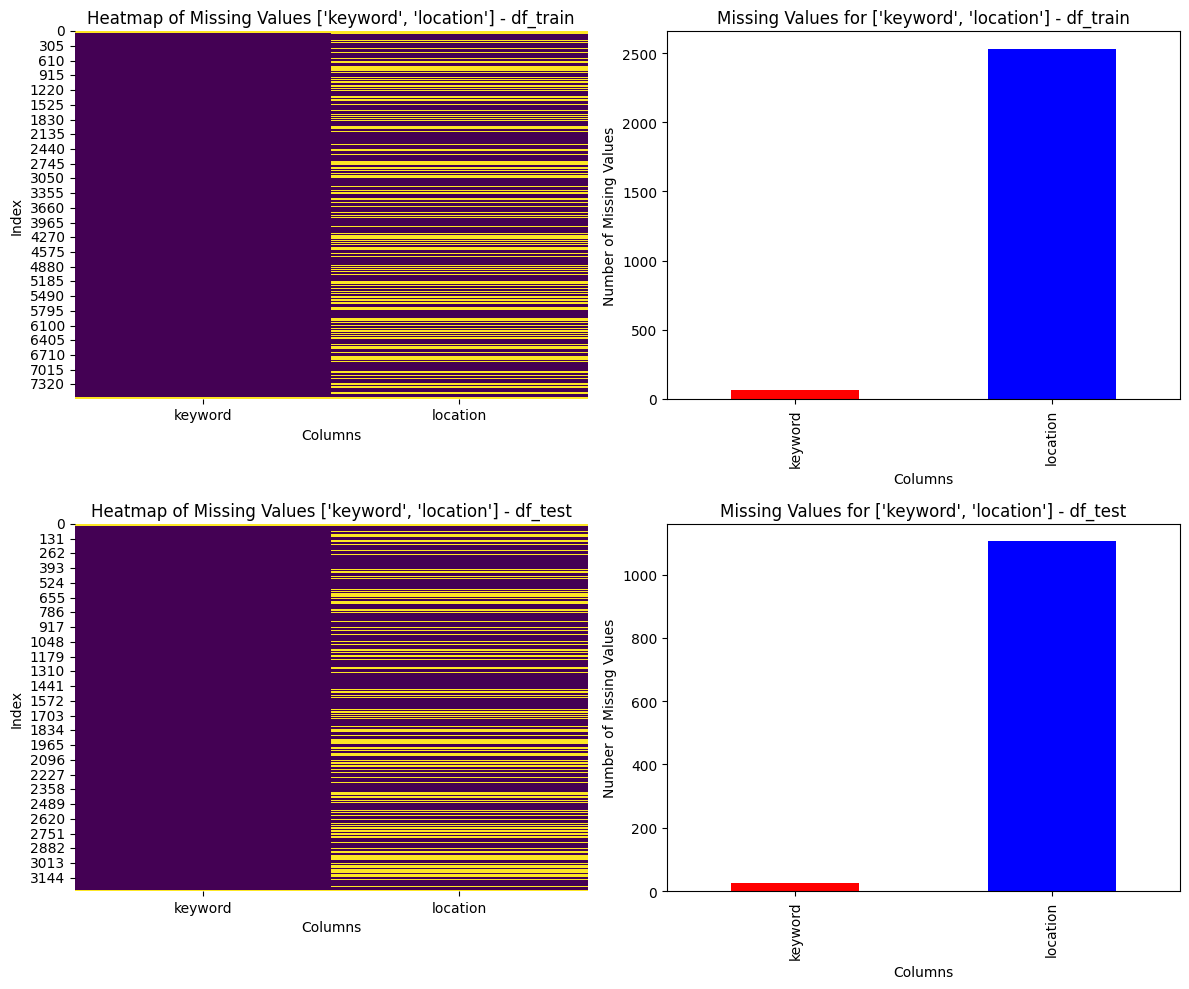

In [9]:
columns_to_check = ["keyword", "location"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.heatmap(df_train[columns_to_check].isnull(), cmap='viridis', cbar=False, ax=axes[0, 0])
axes[0, 0].set_title(f'Heatmap of Missing Values {str(columns_to_check)} - df_train')
axes[0, 0].set_xlabel('Columns')
axes[0, 0].set_ylabel('Index')
missing_counts_train = df_train[columns_to_check].isnull().sum()
missing_counts_train.plot(kind='bar', color=['red', 'blue'], ax=axes[0, 1])
axes[0, 1].set_title(f'Missing Values for {str(columns_to_check)} - df_train')
axes[0, 1].set_xlabel('Columns')
axes[0, 1].set_ylabel('Number of Missing Values')
sns.heatmap(df_test[columns_to_check].isnull(), cmap='viridis', cbar=False, ax=axes[1, 0])
axes[1, 0].set_title(f'Heatmap of Missing Values {str(columns_to_check)} - df_test')
axes[1, 0].set_xlabel('Columns')
axes[1, 0].set_ylabel('Index')
missing_counts_test = df_test[columns_to_check].isnull().sum()
missing_counts_test.plot(kind='bar', color=['red', 'blue'], ax=axes[1, 1])
axes[1, 1].set_title(f'Missing Values for {str(columns_to_check)} - df_test')
axes[1, 1].set_xlabel('Columns')
axes[1, 1].set_ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()


#### 1.3.2 **Location** barchart
* We can inspect the distribution's from barchart's of both disaster and non-disaster tweets to see what is the most likely location's of the tweets.

In [10]:

location_target_counts = df_train.groupby(['location', 'target']).size().reset_index(name='counts')

top_locations = (
    location_target_counts[location_target_counts['target'] == 1]
    .sort_values(by='counts', ascending=False)
    .head(20)
    ['location']
    .tolist()
)
filtered_data = location_target_counts[location_target_counts['location'].isin(top_locations)]

chart = alt.Chart(filtered_data).mark_bar().encode(
    y=alt.Y('location:N', sort=top_locations, title='Location'),
    x=alt.X('counts:Q', title='Counts'),
    color='target:N',  
    tooltip=['location', 'target', 'counts']  
).properties(
    width=500,
    height=800,  
    title='Count of Locations Grouped by Target (Top 20 Locations Sorted by Target 1 Counts)'
)
chart.display()
chart.save("count_of_location_grouped_by_target_top20.html")

alt.Chart(...)

#### 1.3.3 **Keyword** barchart
* We see that certain keywords like **suicide%20bombing** has significantly more counts for **disaster** than the **non-disaster**, which makes sense.

In [11]:
keyword_target_counts = df_train.groupby(['keyword', 'target']).size().reset_index(name='counts')
sorted_keywords = (
    keyword_target_counts[keyword_target_counts['target'] == 1]
    .sort_values(by='counts', ascending=False)['keyword']
    .tolist()
)
chart = alt.Chart(keyword_target_counts).mark_bar().encode(
    y=alt.Y('keyword:N', sort=sorted_keywords, title='Keyword'),
    x=alt.X('counts:Q', title='Counts'),
    color='target:N',  
    tooltip=['keyword', 'target', 'counts'] 
).properties(
    width=500,
    height=2000,
    title='Count of Keywords Grouped by Target (Sorted by Target 1 Counts)'
)
chart.display()
chart.save("count_keywords_grouped_by_target.html")


alt.Chart(...)

#### 1.3.4 Inspect Metadata from **Text** column
* We can create a function that will extract metadata from the **Text** column by appling a function to gather:
    * stopwords
    * url counts
    * average word lengths
    * character counts
    * punctuation counts
    * hashtag counts
    * @ counts
    * word counts
    * unique word counts

In [12]:
def get_metadata(df,stop=stop):
    df['stop_wc'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop])) # stop word count
    df['url_c'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w])) # url word count
    df['avg_w_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()])) # avg word length
    df['char_c'] = df['text'].apply(lambda x: len(str(x))) # character count
    df['punc_c'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) # punctuation count
    df['hashtag_c'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#'])) # hashtag count
    df['at_c'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@'])) # at count
    df['wc'] = df['text'].apply(lambda x: len(str(x).split())) # word count
    df['unique_wc'] = df['text'].apply(lambda x: len(set(str(x).split()))) # unique word count
    return df

In [13]:
df_train = get_metadata(df_train,stop=stop)
df_test = get_metadata(df_test,stop=stop)

In [14]:
df_train

,id,keyword,location,text,target,stop_wc,url_c,avg_w_len,char_c,punc_c,hashtag_c,at_c,wc,unique_wc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,6,0,4.384615,69,1,1,0,13,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,4.571429,38,1,0,0,7,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,11,0,5.090909,133,3,0,0,22,20
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,7.125000,65,2,1,0,8,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,7,0,4.500000,88,2,2,0,16,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,2,1,6.636364,83,5,0,0,11,11
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,9,0,5.300000,125,5,0,2,20,17
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,2,1,7.250000,65,11,0,0,8,8
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,5,0,6.263158,137,5,0,0,19,19


In [15]:
df_test

,id,keyword,location,text,stop_wc,url_c,avg_w_len,char_c,punc_c,hashtag_c,at_c,wc,unique_wc
0,0,NaN,NaN,Just happened a terrible car crash,2,0,4.833333,34,0,0,0,6,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",2,0,6.222222,64,3,1,0,9,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",9,0,4.105263,96,2,0,0,19,19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0,0,9.250000,40,3,2,0,4,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,2,0,4.750000,45,0,0,0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0,0,6.000000,55,0,0,0,8,7
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,6,0,5.086957,139,5,0,0,23,22
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1,1,8.333333,55,5,0,0,6,6
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,0,1,8.428571,65,7,0,0,7,7


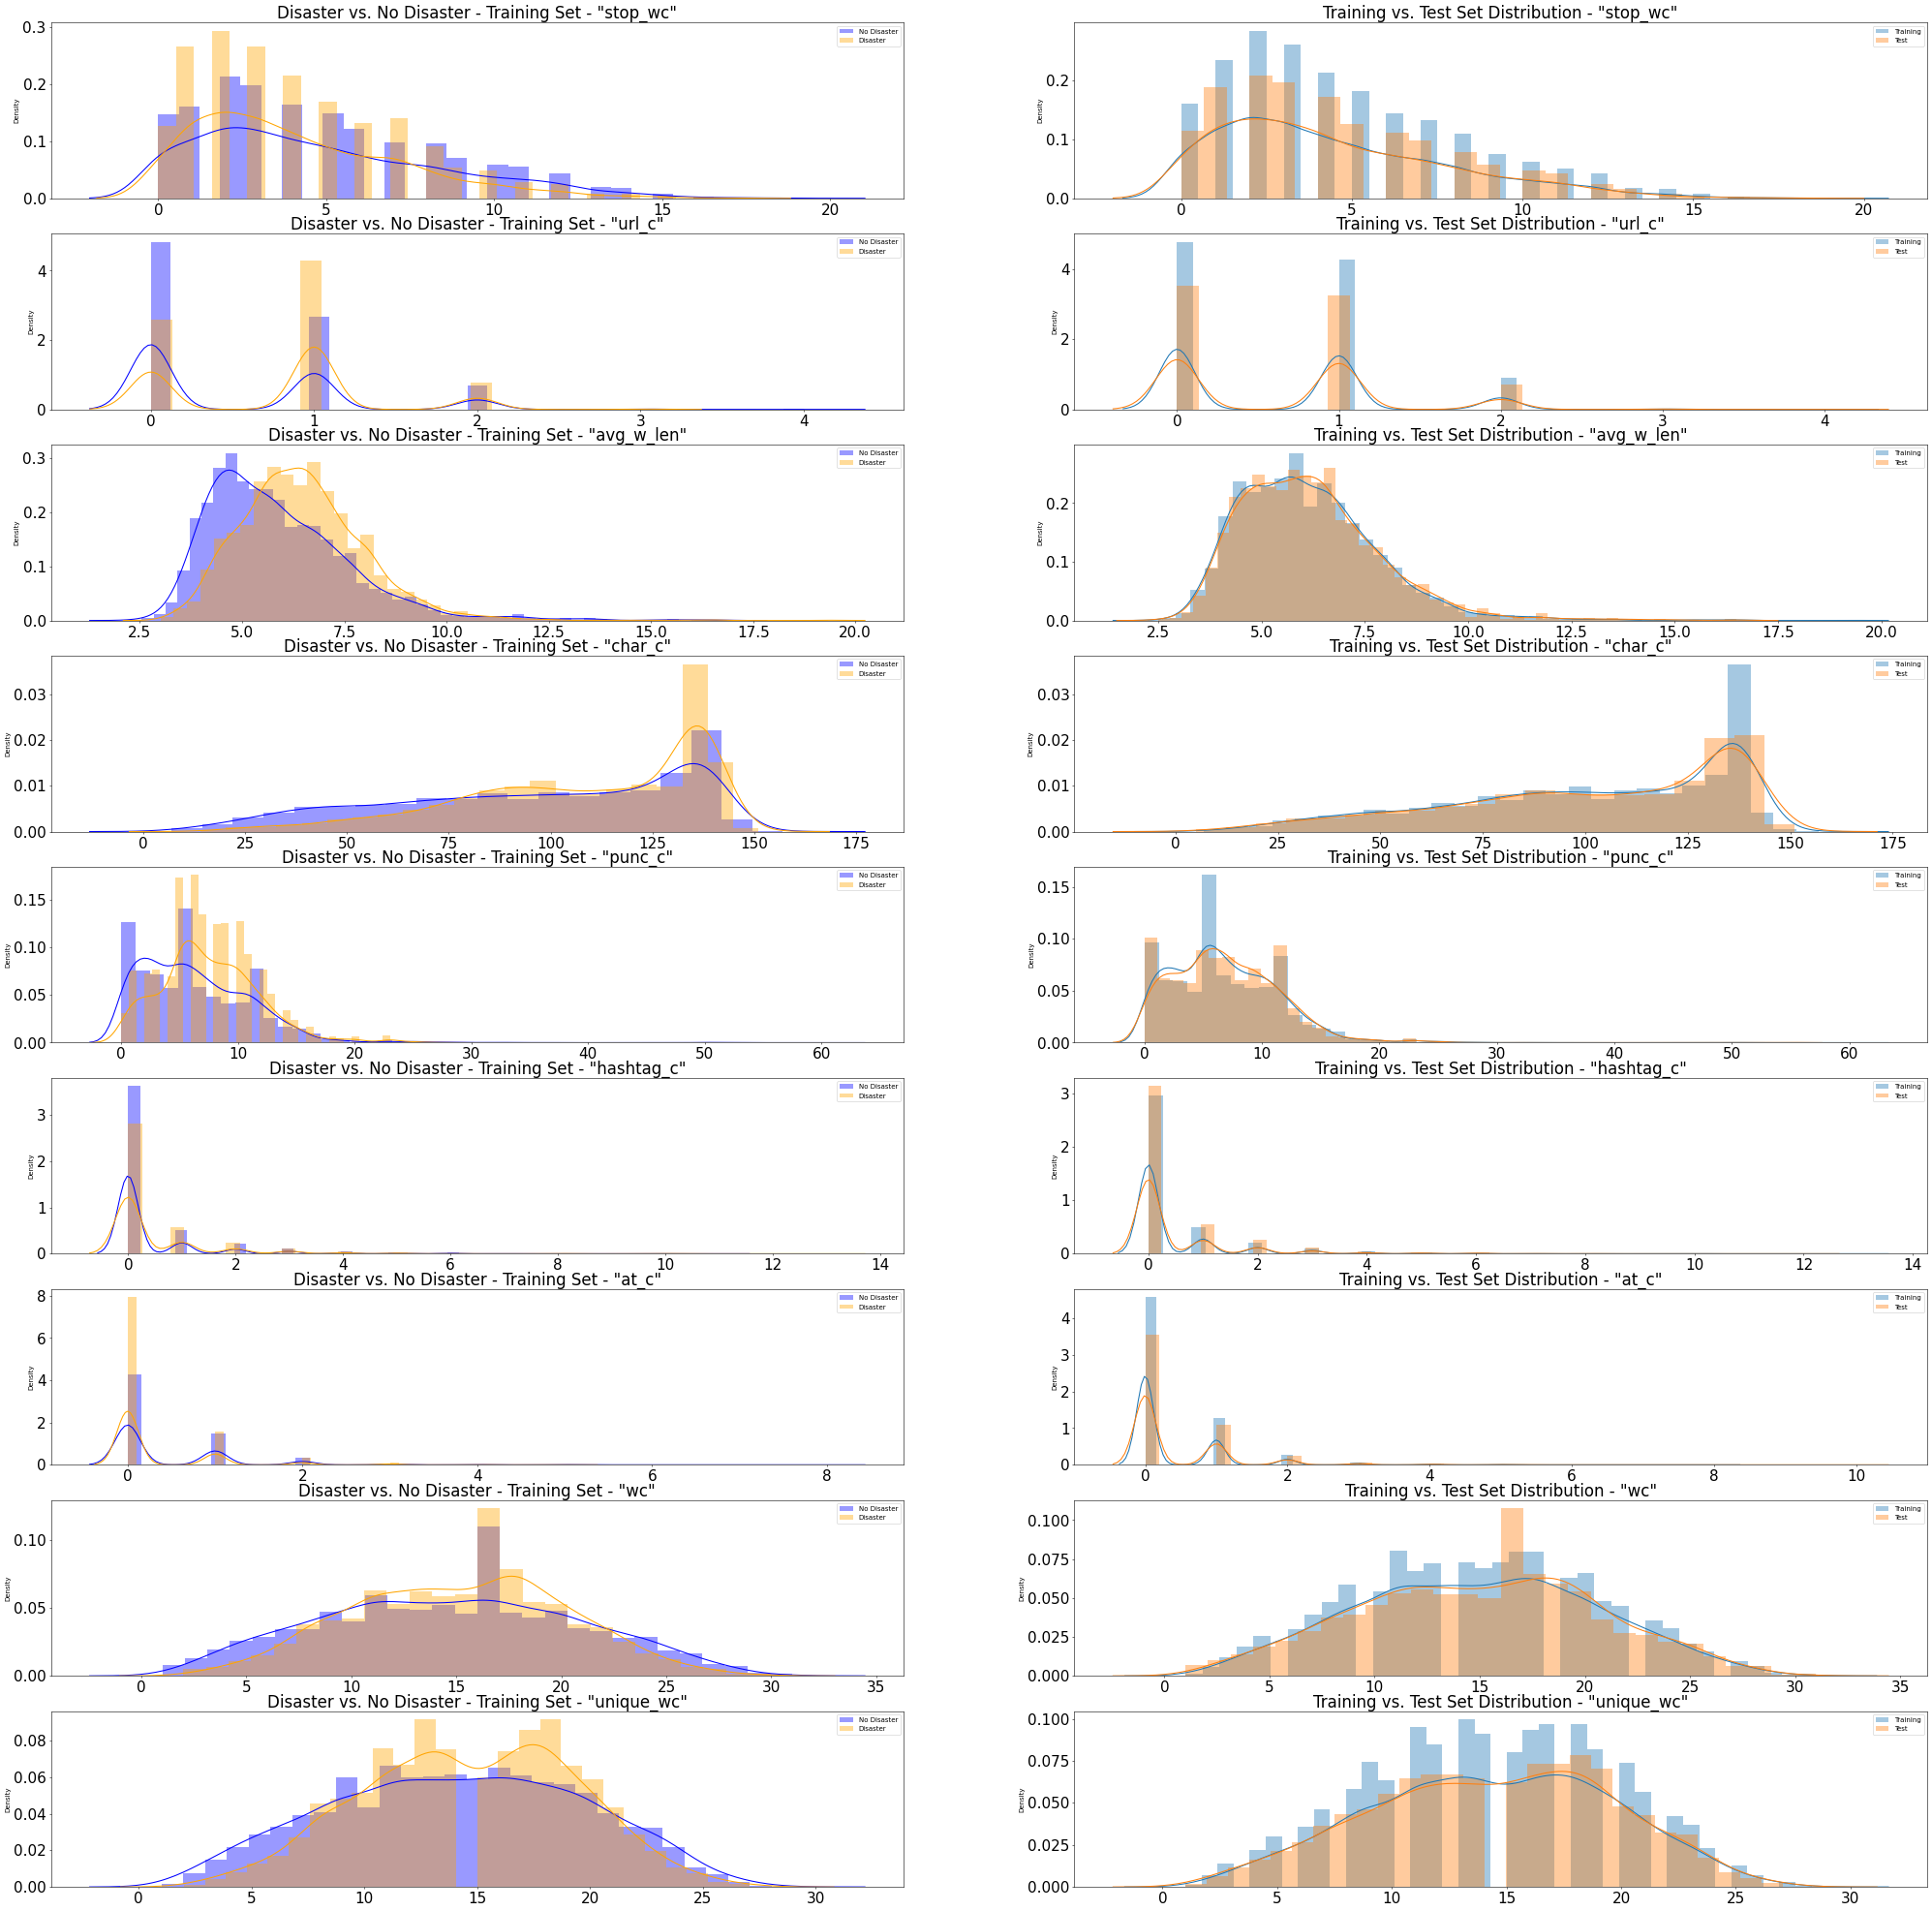

In [16]:
meta_features = ['stop_wc', 'url_c', 'avg_w_len',
                'char_c', 'punc_c', 'hashtag_c', 'at_c','wc', 'unique_wc']
disaster_tweets = df_train['target'] == 1
fig, axes = plt.subplots(ncols=2, nrows=len(meta_features), figsize=(50, 50), dpi=50)
for i, feature_i in enumerate(meta_features):
    sns.distplot(df_train.loc[~disaster_tweets][feature_i], label='No Disaster', ax=axes[i][0], color='blue')
    sns.distplot(df_train.loc[disaster_tweets][feature_i], label='Disaster', ax=axes[i][0], color='orange')
    sns.distplot(df_train[feature_i], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature_i], label='Test', ax=axes[i][1])
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=22)
        axes[i][j].legend()
    axes[i][0].set_title(f'Disaster vs. No Disaster - Training Set - "{feature_i}"', fontsize=24)
    axes[i][1].set_title(f'Training vs. Test Set Distribution - "{feature_i}"', fontsize=24)

plt.show()

#### 1.4 Clean Data

#### 1.4.1 Cleanup the **text** column as **clean_text**
* We can correct spelling text
* We can remove punctuations
* We can can remove numbers
* We can remove stopwords
* We can remove abnormal spelling
* We can make it lower case

In [17]:
def correct_spelling(text):
    corrected_text = []
    misspelled_words = spell_check.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell_check.correction(word))
        else:
            corrected_text.append(word)
    try:
        return_text = " ".join(corrected_text)
    except:
        return_text = text
    return return_text

def cleanup_text(df, text_col,clean_col="clean_text",stopwords=stop):

    import re

    stop_words = stopwords
    df[clean_col] = df[text_col].copy() #copy original text to clean_text for cleaning
    df[clean_col] = [re.sub(r'[^\w\s]+','',w) for w in df[clean_col]]#cleanup punctuations
    df[clean_col] = [re.sub(r'[0-9]+','',w) for w in df[clean_col]]#cleanup numbers
    df[clean_col] = df[clean_col].apply(lambda w: ' '.join([word for word in w.split() if word not in (stop_words)])) #remove stopwords
    df[clean_col] = [re.sub(' +',' ',w) for w in df[clean_col]] #remove abnormal spacing
    df[clean_col] = [correct_spelling(w) for w in df[clean_col]] #spell check
    df[clean_col] = [w.lower() for w in df[clean_col]] #lower case
    return df

#### 1.4.2 Save-Off **clean_text** for easy import
* This step of cleaning data can take over 30 minutes due to the spell-checking, therefore we can save it off for easy loading next time.

In [23]:
RUN_CELL=False
if RUN_CELL:
    df_train = cleanup_text(df_train,"text")
    df_test = cleanup_text(df_test,"text")
    df_train.to_csv("df_train_clean.csv",index=None)
    df_test.to_csv("df_test_clean.csv",index=None)
else:
    df_train = pd.read_csv("df_train_clean.csv",index_col=None)
    df_test = pd.read_csv("df_test_clean.csv",index_col=None)
df_train

,id,keyword,location,text,target,stop_wc,url_c,avg_w_len,char_c,punc_c,hashtag_c,at_c,wc,unique_wc,dataset,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,6,0,4.384615,69,1,1,0,13,13,Training,our deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,4.571429,38,1,0,0,7,7,Training,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,11,0,5.090909,133,3,0,0,22,20,Training,all residents asked shelter place notified off...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,7.125000,65,2,1,0,8,8,Training,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,7,0,4.500000,88,2,2,0,16,15,Training,just got sent photo ruby alaska smoke wildfire...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,2,1,6.636364,83,5,0,0,11,11,Training,two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,9,0,5.300000,125,5,0,2,20,17,Training,aria_ahrary thetawniest the control wild fires...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,2,1,7.250000,65,11,0,0,8,8,Training,m utckm s volcano hawaii httptcozdtoydebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,5,0,6.263158,137,5,0,0,19,19,Training,police investigating bike collided car little ...


## 2.0 Model Architecture
* I will train two different architecture's using scripts:
    * train_custom_GLOVE_LSTM_Bidirectional.py
        * GloVe embeddings from the *glove.twitter.27B.200d.txt* 
        * Bidirectional w/ LSTM for the neural network
    * train_custom_BERT.py
        * pre-trained *bert-base-uncased*
* I will split the training set into an 85% train 15% validate split.

### 2.1 Training with Script

#### 2.1.1 **train_custom_GLOVE_LSTM_Bidirectional.py**


In [27]:
from pprint import pprint
script = "train_custom_GLOVE_LSTM_Bidirectional.py"
with open(script,"r") as f:
    f_read = f.readlines()
pprint(f_read)

['import re\n',
 'from nltk.tokenize import word_tokenize\n',
 'import gensim\n',
 'from keras.preprocessing.text import Tokenizer\n',
 'from keras.preprocessing.sequence import pad_sequences\n',
 'from tqdm import tqdm\n',
 'from keras.models import Sequential\n',
 'from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D\n',
 'from keras.layers import Bidirectional\n',
 'from keras.initializers import Constant\n',
 'from sklearn.model_selection import train_test_split\n',
 'import pandas as pd\n',
 'import string\n',
 'import os\n',
 'import altair as alt\n',
 'import warnings\n',
 'import operator\n',
 'import numpy as np\n',
 'from tensorflow.keras.optimizers import Adam\n',
 'from keras.callbacks import ModelCheckpoint\n',
 'from keras.callbacks import EarlyStopping\n',
 'from keras.models import load_model\n',
 'warnings.filterwarnings("ignore")\n',
 'from nltk.corpus import stopwords\n',
 '\n',
 "stop=set(stopwords.words('english'))\n",
 'path_main = "nlp-getting-started"\

#### 2.1.2 **train_custom_BERT.py**


In [28]:
from pprint import pprint
script = "train_custom_BERT.py"
with open(script,"r") as f:
    f_read = f.readlines()
pprint(f_read)

['import os\n',
 'import pandas as pd\n',
 'import numpy as np\n',
 'from sklearn.model_selection import train_test_split\n',
 'from transformers import BertTokenizer, TFBertForSequenceClassification\n',
 'from transformers import EarlyStoppingCallback\n',
 'from tensorflow.keras.optimizers import Adam\n',
 'from tensorflow.keras.callbacks import ModelCheckpoint\n',
 'import tensorflow as tf\n',
 'from tqdm import tqdm\n',
 'import datetime\n',
 'from keras.callbacks import ModelCheckpoint, EarlyStopping\n',
 '\n',
 'path_main = "nlp-getting-started"\n',
 'train_csv = os.path.join(path_main, "train.csv")\n',
 'test_csv = os.path.join(path_main, "test.csv")\n',
 'sample_submission_csv = os.path.join(path_main, "sample_submission.csv")\n',
 '\n',
 'df_sample_submission = pd.read_csv(sample_submission_csv)\n',
 'df_train = pd.read_csv("df_train_clean.csv", index_col=None)\n',
 'df_test = pd.read_csv("df_test_clean.csv", index_col=None)\n',
 '\n',
 "tokenizer = BertTokenizer.from_pretraine

### 2.2 Reading in Models

In [29]:
TRAIN_MODELS_PATHS  = os.listdir()
TRAIN_MODELS_PATHS = [w for w in TRAIN_MODELS_PATHS if w.find("MODELS")!=-1]
TRAIN_MODELS_PATHS

['MODELS']

In [30]:
projects = []
for path_i in TRAIN_MODELS_PATHS:
    projects += [os.path.join(path_i,w) for w in os.listdir(path_i)]
projects

['MODELS/2024-10-08_02-48-57p942695_BERT',
 'MODELS/2024-10-07_23-04-47p834977_BERT',
 'MODELS/2024-10-08_06-21-43p556549_BERT',
 'MODELS/2024-10-08_12-34-52p485713_BERT',
 'MODELS/2024-10-07_12-33-36p589252_gloveptwitterp27Bp200d',
 'MODELS/2024-10-09_06-27-21p649515_gloveptwitterp27Bp200d']

In [36]:
names_found_all = []
weights_found = {}
for project in projects:
    names_found = os.listdir(project)
    if project.lower().find("bert")!=-1:
        weights = "tf_model.h5"
    else:
        weights = "model.h5"
    path_weights = os.path.join(project,weights)
    path_results = os.path.join(project,"training_history.csv")

    weights_found[project] = [path_weights,path_results]

In [37]:
weights_found

{'MODELS/2024-10-08_02-48-57p942695_BERT': ['MODELS/2024-10-08_02-48-57p942695_BERT/tf_model.h5',
  'MODELS/2024-10-08_02-48-57p942695_BERT/training_history.csv'],
 'MODELS/2024-10-07_23-04-47p834977_BERT': ['MODELS/2024-10-07_23-04-47p834977_BERT/tf_model.h5',
  'MODELS/2024-10-07_23-04-47p834977_BERT/training_history.csv'],
 'MODELS/2024-10-08_06-21-43p556549_BERT': ['MODELS/2024-10-08_06-21-43p556549_BERT/tf_model.h5',
  'MODELS/2024-10-08_06-21-43p556549_BERT/training_history.csv'],
 'MODELS/2024-10-08_12-34-52p485713_BERT': ['MODELS/2024-10-08_12-34-52p485713_BERT/tf_model.h5',
  'MODELS/2024-10-08_12-34-52p485713_BERT/training_history.csv'],
 'MODELS/2024-10-07_12-33-36p589252_gloveptwitterp27Bp200d': ['MODELS/2024-10-07_12-33-36p589252_gloveptwitterp27Bp200d/model.h5',
  'MODELS/2024-10-07_12-33-36p589252_gloveptwitterp27Bp200d/training_history.csv'],
 'MODELS/2024-10-09_06-27-21p649515_gloveptwitterp27Bp200d': ['MODELS/2024-10-09_06-27-21p649515_gloveptwitterp27Bp200d/model.h5'

## 3. Results & Analysis 
* I will read in each result file for each model generated.
* I will sort them by accuracy and remove duplicates per model to see the top models.
    * It appears BERT performed best, but overfitting was seen if trained too long.  
* I will take the best model from this list and inference on the *TEST* set for uploading results to Kaggle

In [60]:
dfs = []
for k,v in weights_found.items():
    df_i = pd.read_csv(v[1])
    df_i["NAME"] = k
    df_i["MODEL_PATH"] = v[0]
    df_i["MODEL_TYPE"] = k.split("_")[-1]
    dfs.append(df_i)
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,loss,accuracy,val_loss,val_accuracy,NAME,MODEL_PATH,MODEL_TYPE
0,0.453083,0.792304,0.407735,0.814361,MODELS/2024-10-08_02-48-57p942695_BERT,MODELS/2024-10-08_02-48-57p942695_BERT/tf_mode...,BERT
1,0.326169,0.865245,0.456510,0.813485,MODELS/2024-10-08_02-48-57p942695_BERT,MODELS/2024-10-08_02-48-57p942695_BERT/tf_mode...,BERT
2,0.224472,0.910369,0.546871,0.809982,MODELS/2024-10-08_02-48-57p942695_BERT,MODELS/2024-10-08_02-48-57p942695_BERT/tf_mode...,BERT
3,0.139421,0.950549,0.719731,0.806480,MODELS/2024-10-08_02-48-57p942695_BERT,MODELS/2024-10-08_02-48-57p942695_BERT/tf_mode...,BERT
4,0.455797,0.786123,0.423067,0.835377,MODELS/2024-10-07_23-04-47p834977_BERT,MODELS/2024-10-07_23-04-47p834977_BERT/tf_mode...,BERT
5,0.322689,0.865554,0.466233,0.818739,MODELS/2024-10-07_23-04-47p834977_BERT,MODELS/2024-10-07_23-04-47p834977_BERT/tf_mode...,BERT
6,0.217487,0.916705,0.505375,0.821366,MODELS/2024-10-07_23-04-47p834977_BERT,MODELS/2024-10-07_23-04-47p834977_BERT/tf_mode...,BERT
7,0.454583,0.787359,0.429992,0.830998,MODELS/2024-10-08_06-21-43p556549_BERT,MODELS/2024-10-08_06-21-43p556549_BERT/tf_mode...,BERT
8,0.325336,0.867718,0.420774,0.819615,MODELS/2024-10-08_06-21-43p556549_BERT,MODELS/2024-10-08_06-21-43p556549_BERT/tf_mode...,BERT
9,0.223231,0.914078,0.595396,0.815236,MODELS/2024-10-08_06-21-43p556549_BERT,MODELS/2024-10-08_06-21-43p556549_BERT/tf_mode...,BERT


In [61]:
combined_df.sort_values(by="val_accuracy",ascending=False).drop_duplicates("MODEL_PATH")

,loss,accuracy,val_loss,val_accuracy,NAME,MODEL_PATH,MODEL_TYPE
4,0.455797,0.786123,0.423067,0.835377,MODELS/2024-10-07_23-04-47p834977_BERT,MODELS/2024-10-07_23-04-47p834977_BERT/tf_mode...,BERT
7,0.454583,0.787359,0.429992,0.830998,MODELS/2024-10-08_06-21-43p556549_BERT,MODELS/2024-10-08_06-21-43p556549_BERT/tf_mode...,BERT
13,0.323751,0.863700,0.471967,0.823117,MODELS/2024-10-08_12-34-52p485713_BERT,MODELS/2024-10-08_12-34-52p485713_BERT/tf_mode...,BERT
0,0.453083,0.792304,0.407735,0.814361,MODELS/2024-10-08_02-48-57p942695_BERT,MODELS/2024-10-08_02-48-57p942695_BERT/tf_mode...,BERT
45,0.416999,0.814094,0.443242,0.814361,MODELS/2024-10-09_06-27-21p649515_gloveptwitte...,MODELS/2024-10-09_06-27-21p649515_gloveptwitte...,gloveptwitterp27Bp200d
20,0.508203,0.770978,0.483343,0.795972,MODELS/2024-10-07_12-33-36p589252_gloveptwitte...,MODELS/2024-10-07_12-33-36p589252_gloveptwitte...,gloveptwitterp27Bp200d


In [62]:
combined_df.sort_values(by="accuracy",ascending=False).drop_duplicates("MODEL_PATH")

,loss,accuracy,val_loss,val_accuracy,NAME,MODEL_PATH,MODEL_TYPE
11,0.095437,0.960130,0.684382,0.804729,MODELS/2024-10-08_06-21-43p556549_BERT,MODELS/2024-10-08_06-21-43p556549_BERT/tf_mode...,BERT
3,0.139421,0.950549,0.719731,0.806480,MODELS/2024-10-08_02-48-57p942695_BERT,MODELS/2024-10-08_02-48-57p942695_BERT/tf_mode...,BERT
15,0.149422,0.942049,0.583235,0.798599,MODELS/2024-10-08_12-34-52p485713_BERT,MODELS/2024-10-08_12-34-52p485713_BERT/tf_mode...,BERT
6,0.217487,0.916705,0.505375,0.821366,MODELS/2024-10-07_23-04-47p834977_BERT,MODELS/2024-10-07_23-04-47p834977_BERT/tf_mode...,BERT
45,0.416999,0.814094,0.443242,0.814361,MODELS/2024-10-09_06-27-21p649515_gloveptwitte...,MODELS/2024-10-09_06-27-21p649515_gloveptwitte...,gloveptwitterp27Bp200d
28,0.461778,0.801576,0.470366,0.788967,MODELS/2024-10-07_12-33-36p589252_gloveptwitte...,MODELS/2024-10-07_12-33-36p589252_gloveptwitte...,gloveptwitterp27Bp200d


### 3.1 Hyperparameter Tuning Results

* I will show I used different numbers of neurons for some of the models when training with the scripts to see effects on the LSTM.
* It appears that for the GloVe embedding model's that the Bidirectional model's had better accuracy than the non-Bidirectional model's likely because the *context* of the text was better understood.
    * This had nearly a **3% improvement on the validation accuracy**.


In [70]:
example_model_1 = combined_df.sort_values(by="val_accuracy",ascending=False).drop_duplicates("MODEL_PATH").MODEL_PATH.iloc[-2]
print(example_model_1)
model_1 = load_model(example_model_1)
print(model_1.summary())
example_model_2 = combined_df.sort_values(by="val_accuracy",ascending=False).drop_duplicates("MODEL_PATH").MODEL_PATH.iloc[-1]
print(example_model_2)
model_2 = load_model(example_model_2)
print(model_2.summary())

MODELS/2024-10-09_06-27-21p649515_gloveptwitterp27Bp200d/model.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 200)           5337400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 75, 200)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 300)              421200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 5,758,901
Trainable params: 421,501
Non-trainable params: 5,337,400
________________________________________

### 3.2 Training/Validation Loss/Accuracy curves
* We can see BERT started overfitting much sooner than the GloVe embedded models.
* We can also see BERT outperformed the other models based on the number of epochs trained.

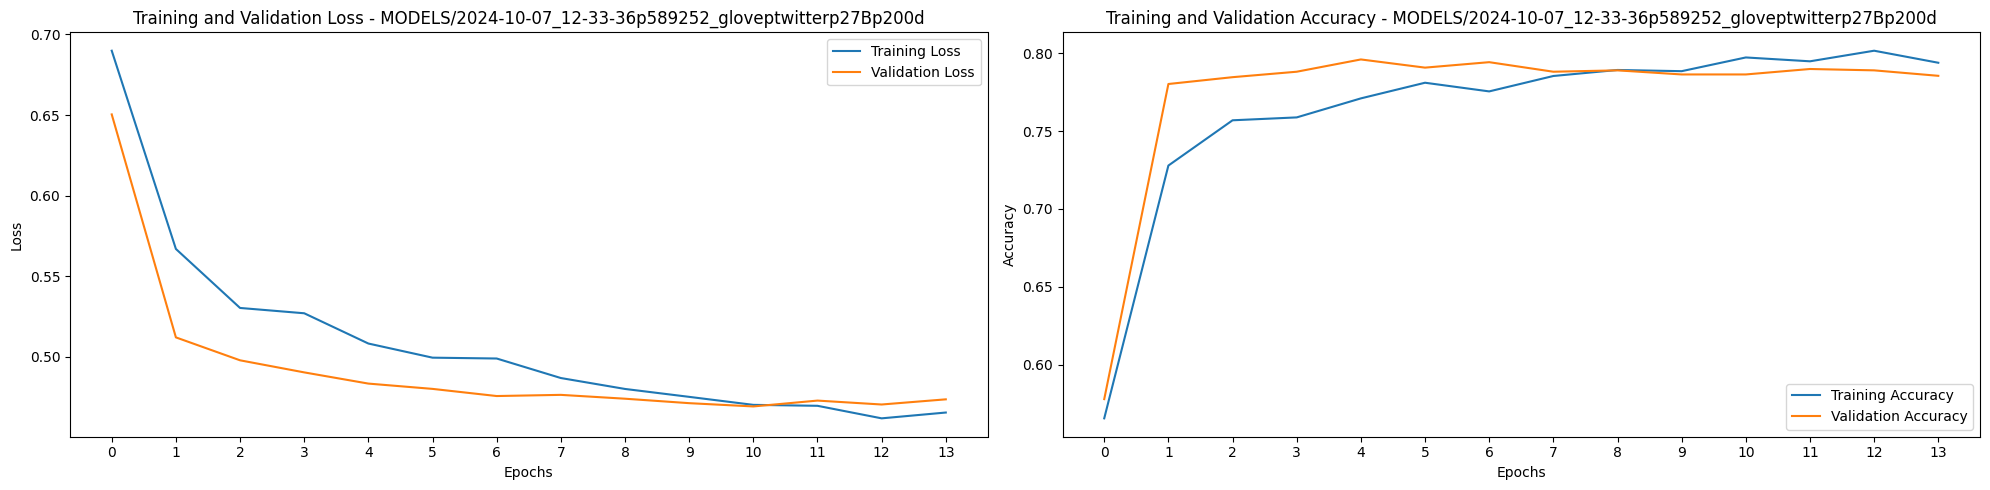

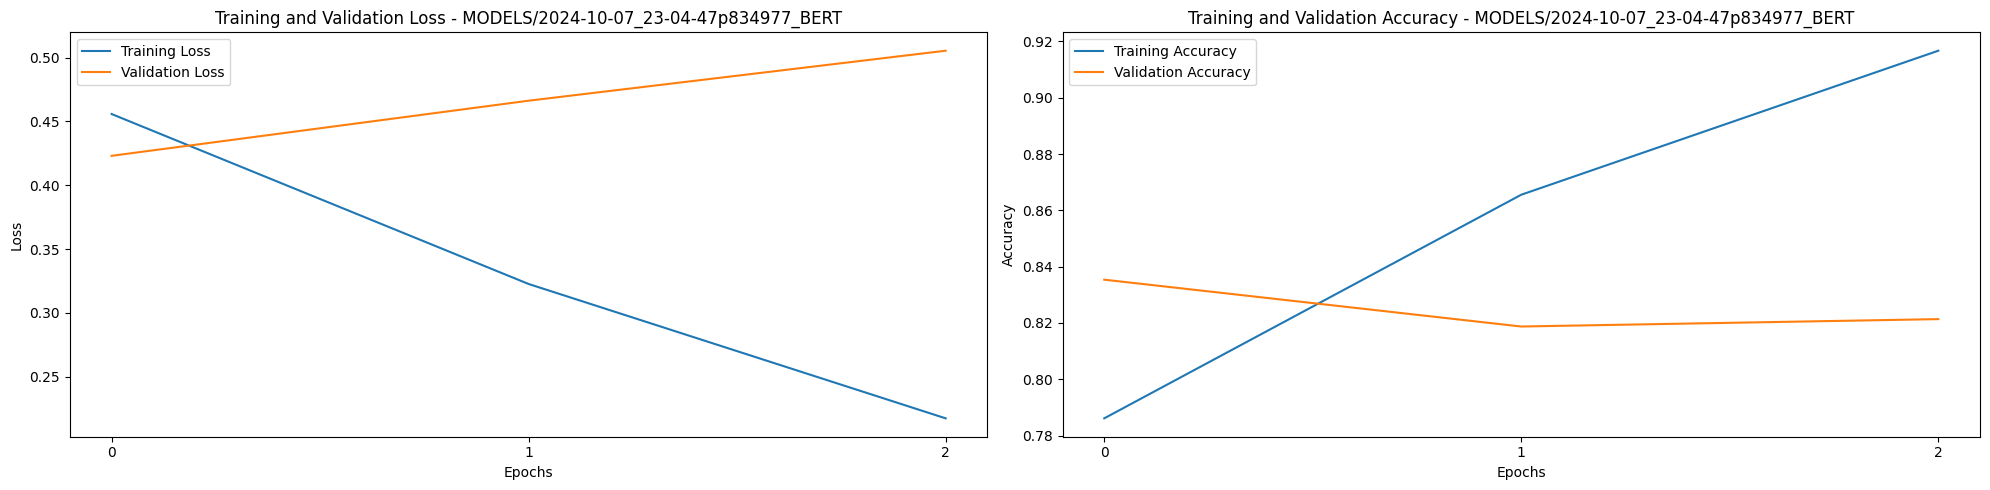

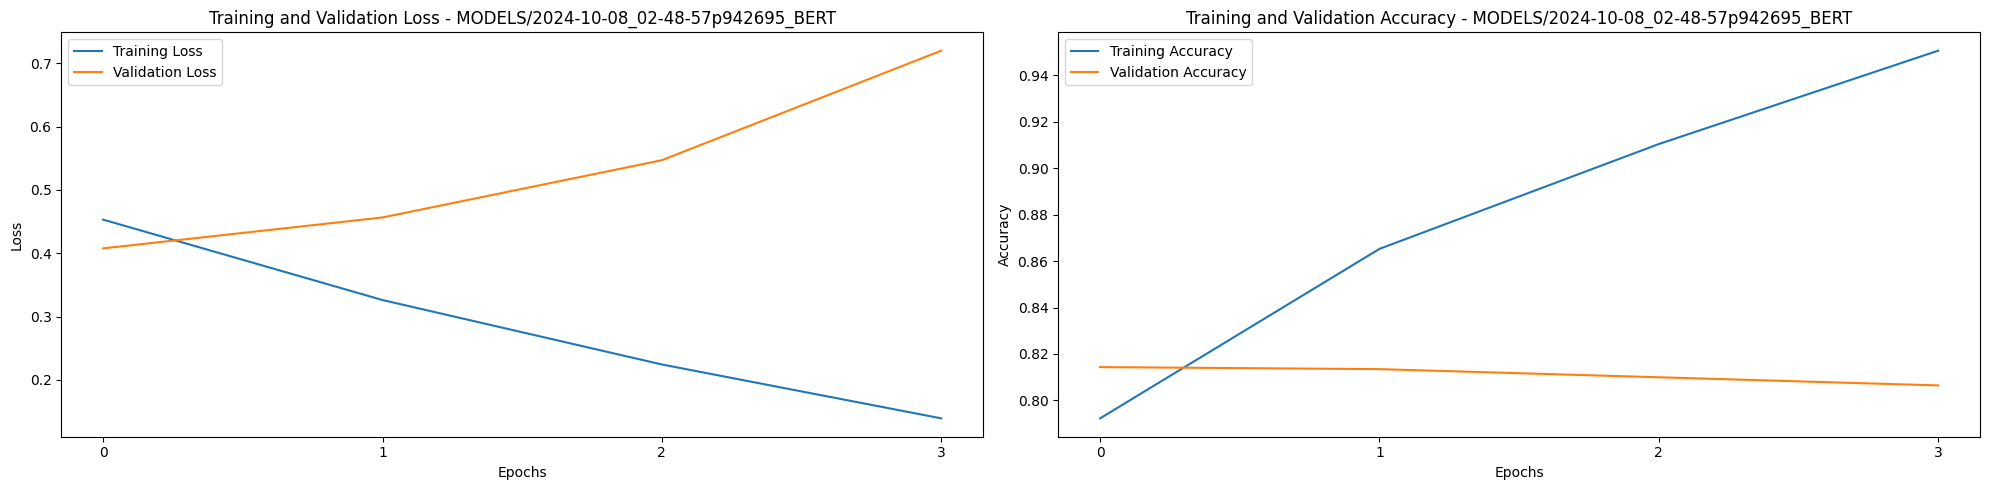

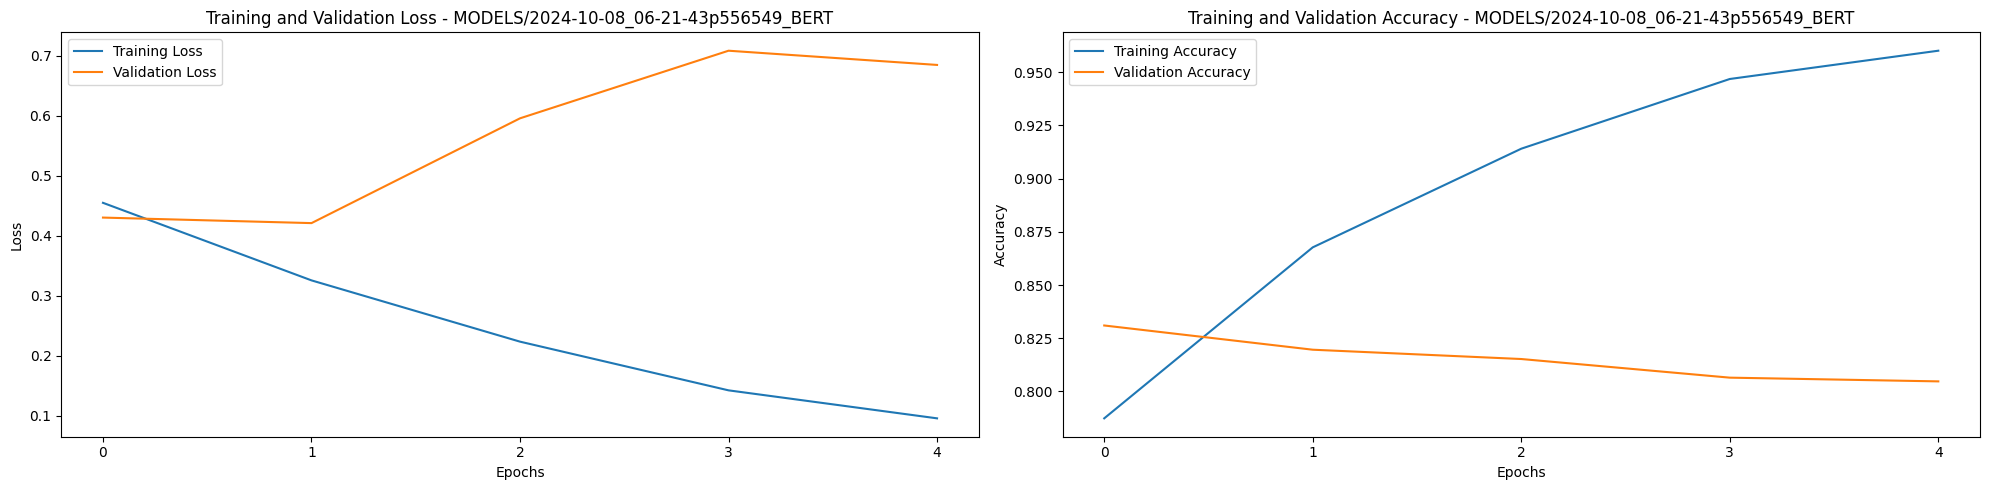

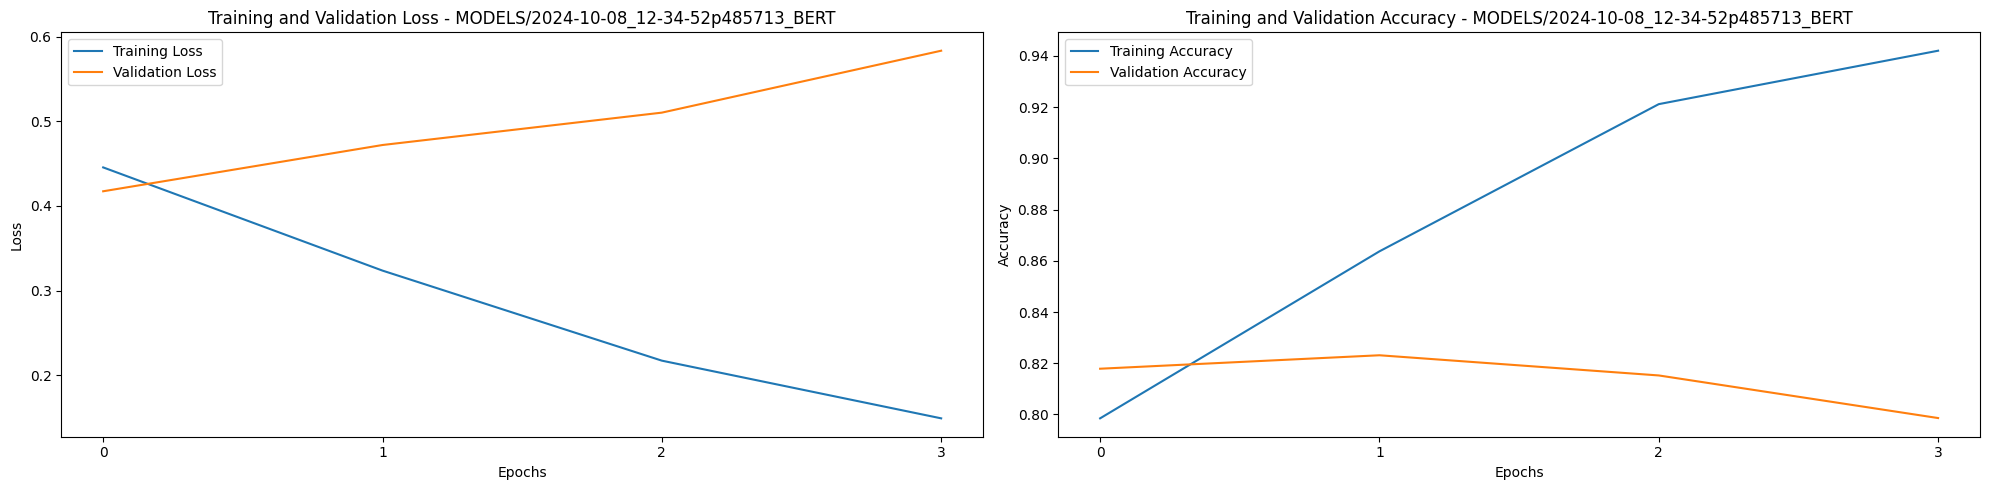

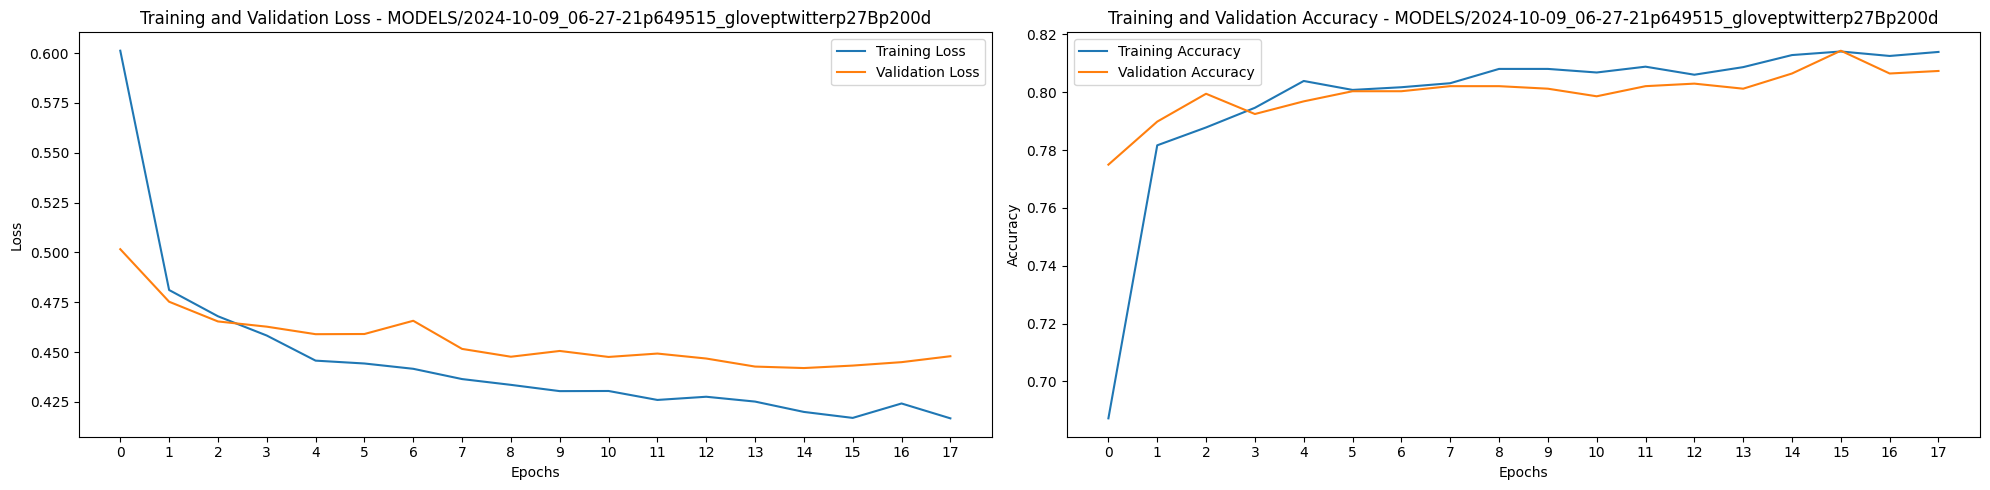

In [55]:
model_groups = combined_df.groupby('MODEL_PATH')

for model_path, model_data in model_groups:
    epochs = range(len(model_data))
    
    plt.figure(figsize=(20, 5))
    #Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model_data['loss'], label='Training Loss')
    plt.plot(epochs, model_data['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_path}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(ticks=[i for i in epochs if i % 1 == 0])
    #Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model_data['accuracy'], label='Training Accuracy')
    plt.plot(epochs, model_data['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_path}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(ticks=[i for i in epochs if i % 1 == 0])
    
    plt.tight_layout()
    plt.show()


### 3.3 Kaggle Results
* My highest performing BERT model above did best on the actual **TEST** set as expected.

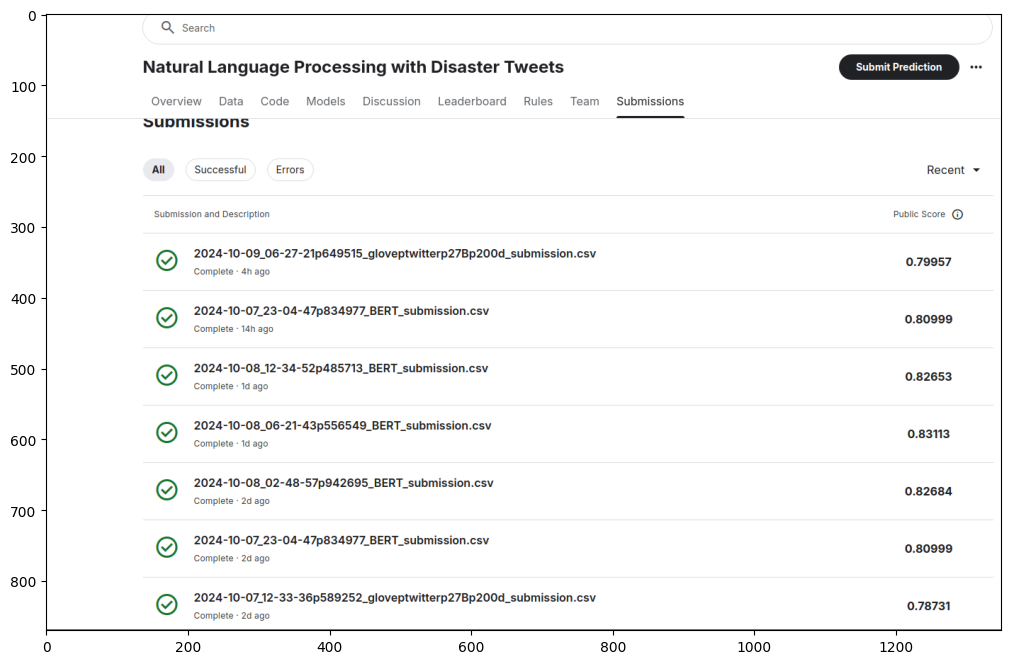

In [71]:
plt.figure(figsize=(20, 8))
plt.imshow(plt.imread("Screenshot from 2024-10-09 20-06-27.png"))
plt.show()

## 4.0 Conclusions
* It appears that a larger architecture peforms better than a smaller one due to the large amount of diversity in the dataset that overfitting is less of an issue.  
    * So BERT performed better than the embedding GloVe model's I trained, as well as more deep GloVe model's performed better amongst each themselves.
* When training a LSTM GloVe model, having more neurons with this dataset in the LSTM layer helps improve accuracy as well as adding an additional *Bidirectional* layer.
* Performance was not significantly different between what I observed in my TRAIN/VALIDATION split compared to TEST with Kaggle.
* Possibly training for a greater number of layers and/or hyperparameters could improve future models.
    * These model's took over a day at time to train on my Jetson ORIN AGX.  So the hardware limited me from trying all of the extra cases.

# References
* https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
* https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
* https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove